 # Crawl domain
 
 https://github.com/openai/openai-cookbook/blob/45c6406e8bb42e502d0394a9f1d217e5494ba4a2/apps/web-crawl-q-and-a/web-qa.ipynb

In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
from typing import List, Optional, Set


HTTP_URL_PATTERN = re.compile(r'^http[s]*://.+')


def sanitize_filename(filename: str) -> str:
    return re.sub(r'[\\/*?:"<>|]', "", filename)

def create_directory(path: str):
    if not os.path.exists(path):
        os.mkdir(path)

def is_html(response) -> bool:
    return response.info().get('Content-Type').startswith("text/html")

def read_url(url: str) -> Optional[str]:
    try:
        with urllib.request.urlopen(url) as response:
            if not is_html(response):
                return None
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return None

class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks: List[str] = []

    def handle_starttag(self, tag: str, attrs: List[str]):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

def get_hyperlinks(url: str) -> List[str]:
    html = read_url(url)
    if html is None:
        return []
    parser = HyperlinkParser()
    parser.feed(html)
    return parser.hyperlinks

def filter_domain_links(local_domain: str, links: List[str]) -> Set[str]:
    clean_links = set()
    for link in links:
        if HTTP_URL_PATTERN.match(link):
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_links.add(link)
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_links.add("https://" + local_domain + "/" + link)
    return clean_links

def crawl(domain: str, root_url: str):
    local_domain = urlparse(root_url).netloc

    queue = deque([root_url])
    seen = set([root_url])

    create_directory("text/")
    create_directory(f"text/{local_domain}/")
    create_directory("processed/")

    while queue:
        url = queue.pop()
        print(f"Crawling: {url}")

        html_text = requests.get(url).text
        soup = BeautifulSoup(html_text, "html.parser")
        text = soup.get_text()

        filename = sanitize_filename(url[8:].replace("/", "_"))
        with open(f'text/{local_domain}/{filename}.txt', "w", encoding='utf-8') as f:
            f.write(text)

        new_links = get_hyperlinks(url)
        domain_links = filter_domain_links(local_domain, new_links)

        for link in domain_links:
            if link not in seen:
                queue.append(link)
                seen.add(link)

In [2]:
DOMAIN = "lupinetravel.co.uk"
ROOT_URL = "https://lupinetravel.co.uk/"
crawl(DOMAIN, ROOT_URL)

Crawling: https://lupinetravel.co.uk/
Crawling: https://lupinetravel.co.uk/south-sudan-holidays-and-tours/
Crawling: https://lupinetravel.co.uk/all-tours/south-sudan-highlights-tour-nov23/
Crawling: https://lupinetravel.co.uk/all-tours/south-sudan-highlights-tour-feb24/
Crawling: https://lupinetravel.co.uk/?add-to-cart=38393
Crawling: https://lupinetravel.co.uk/?add-to-cart=44023
Crawling: https://lupinetravel.co.uk
Crawling: https://lupinetravel.co.uk/new-introducing-the-cameroon-e-visa/
Crawling: https://lupinetravel.co.uk/what-is-the-mighty-iron-ore-train-heres-everything-you-need-to-know/
Crawling: https://lupinetravel.co.uk/blogs/
Crawling: https://lupinetravel.co.uk/how-to-guide-getting-a-pcr-test-in-istanbul-ist-airport/
Crawling: https://lupinetravel.co.uk/a-visit-to-sealand-by-mike-kendall/
Crawling: https://lupinetravel.co.uk/who-goes-on-a-lupine-travel-tour-by-james-finnerty/
Crawling: https://lupinetravel.co.uk/socotra-island-travel-everything-you-need-to-know/
Crawling: ht

In [3]:
from typing import List, Tuple
import os
import pandas as pd
from pandas import Series

def remove_newlines(serie: Series) -> Series:
    """Removes newline and escaped newline characters from a Pandas Series."""
    return serie.str.replace(r'\\n|\n', ' ', regex=True)

def remove_extra_spaces(serie: Series) -> Series:
    """Replaces multiple spaces with a single space in a Pandas Series."""
    return serie.str.replace(r'\s+', ' ', regex=True)

def remove_newlines_and_extra_spaces(serie: Series) -> Series:
    """Removes newlines and replaces multiple spaces with a single space in a Pandas Series."""
    serie = remove_newlines(serie)
    return remove_extra_spaces(serie)

def process_text_files(domain: str, output_csv: str) -> pd.DataFrame:
    texts: List[Tuple[str, str]] = []

    dir_path = f"text/{domain}/"

    for file in os.listdir(dir_path):
        with open(f"{dir_path}{file}", "r", encoding='utf-8') as f:
            text = f.read()
            sanitized_name = file[11:-4].replace('-', ' ').replace('_', ' ').replace('#update', '')
            texts.append((sanitized_name, text))

    df = pd.DataFrame(texts, columns=['fname', 'text'])
    df['text'] = df.fname + ". " + remove_newlines_and_extra_spaces(df.text)
    df.to_csv(output_csv, index=False)
    
    return df


In [5]:
output_csv = "processed/scraped.csv"
df = process_text_files(DOMAIN, output_csv)
print(df.head())

                                               fname  \
0                                            l.co.uk   
1                                           l.co.uk    
2  l.co.uk 193 club interview series part 1 david...   
3  l.co.uk 193 club interview series part 2 mike ...   
4  l.co.uk 193 club interview series part 3 harol...   

                                                text  
0  l.co.uk.  Lupine Travel | Tours to Unique and ...  
1  l.co.uk .  Lupine Travel | Tours to Unique and...  
2  l.co.uk 193 club interview series part 1 david...  
3  l.co.uk 193 club interview series part 2 mike ...  
4  l.co.uk 193 club interview series part 3 harol...  


In [6]:
from tiktoken import get_encoding
import matplotlib.pyplot as plt

def load_dataframe(csv_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(csv_path, index_col=0)
    except FileNotFoundError:
        print(f"File {csv_path} not found.")
        return pd.DataFrame()
    #df.columns = ['title', 'text']
    return df

def tokenize_dataframe(df: pd.DataFrame, tokenizer) -> pd.DataFrame:
    df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
    return df

def plot_histogram(df: pd.DataFrame, column: str):
    plt.hist(df[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.show()

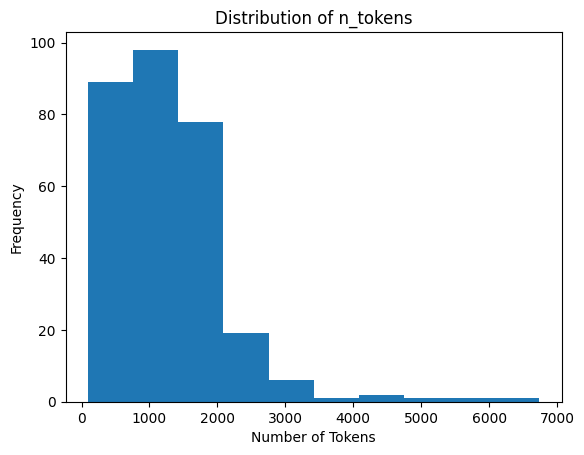

In [7]:
# Load the cl100k_base tokenizer
tokenizer = get_encoding("cl100k_base")

# Load the DataFrame
csv_path = 'processed/scraped.csv'
df = load_dataframe(csv_path)

# Tokenize the DataFrame
df = tokenize_dataframe(df, tokenizer)

# Plot the histogram
plot_histogram(df, 'n_tokens')

In [8]:
# Function to split text into chunks based on the max number of tokens
def split_into_many(text: str, max_tokens: int, tokenizer) -> List[str]:
    sentences = text.split('. ')
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks, tokens_so_far, chunk = [], 0, []

    for sentence, token in zip(sentences, n_tokens):
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        if token > max_tokens:
            continue

        chunk.append(sentence)
        tokens_so_far += token + 1
    
    return chunks

def split_dataframe_texts(df: pd.DataFrame, max_tokens: int, tokenizer) -> List[str]:
    shortened = []
    for _, row in df.iterrows():
        if row['text'] is None:
            continue

        if row['n_tokens'] > max_tokens:
            shortened += split_into_many(row['text'], max_tokens, tokenizer)
        else:
            shortened.append(row['text'])
    
    return shortened

In [9]:
shortened = split_dataframe_texts(df, 500, tokenizer)

<Axes: >

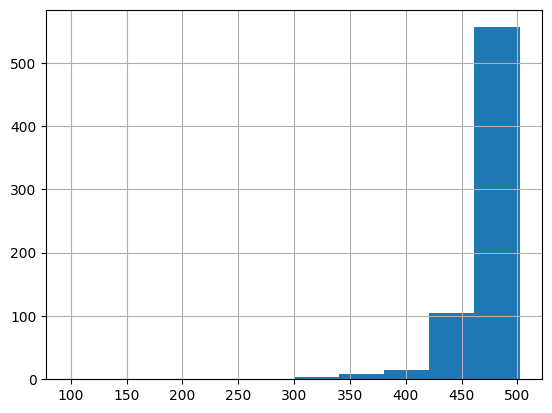

In [10]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [11]:
import openai
from dotenv import dotenv_values
openai.api_key = dotenv_values(".env")['OPENAI_API_KEY']

In [12]:
#df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
#df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,l.co.uk. Lupine Travel | Tours to Unique and ...,455,"[0.012679794803261757, -0.005423983093351126, ..."
1,l.co.uk . Lupine Travel | Tours to Unique and...,455,"[0.012838529422879219, -0.00545841921120882, 0..."
2,l.co.uk 193 club interview series part 1 david...,499,"[0.005527153145521879, -0.025953589007258415, ..."
3,Our family would go camping every June at the ...,501,"[0.014469685032963753, -0.0074482024647295475,..."
4,One of the best things about living in Germany...,472,"[0.015787804499268532, -0.011699066497385502, ..."


In [13]:
import numpy as np
from ast import literal_eval

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,l.co.uk. Lupine Travel | Tours to Unique and ...,455,"[0.012679794803261757, -0.005423983093351126, ..."
1,l.co.uk . Lupine Travel | Tours to Unique and...,455,"[0.012838529422879219, -0.00545841921120882, 0..."
2,l.co.uk 193 club interview series part 1 david...,499,"[0.005527153145521879, -0.025953589007258415, ..."
3,Our family would go camping every June at the ...,501,"[0.014469685032963753, -0.0074482024647295475,..."
4,One of the best things about living in Germany...,472,"[0.015787804499268532, -0.011699066497385502, ..."


In [53]:
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity
import pprint

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"""
            You are a helpful assistant working on behalf of Lupine Travel.
            Answer the question based on the context below. Your main task
            is to provide information to clients which will help them understand
            if a trip is suitable for them.
            If the question can't be answered based on the context, say
            \"I don't know\"\n\n
            Context: {context}\n\n---
            \n\nQuestion: {question}\n
            Answer:""",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return pprint.pprint(response["choices"][0]["text"].strip())
    except Exception as e:
        print(e)
        return ""


from openai.embeddings_utils import get_embedding, cosine_similarity

def search_similar(df, question, n=3, pprint=True):
    product_embedding = get_embedding(
        question,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embeddings.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)["text"]
        .head(n)
        #.combined.str.replace("Title: ", "")
        #.str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results




In [39]:
answer_question(df, question="How much does a trip to South Sudan cost?", debug=False)

('Our South Sudan tours are priced at £2085 per person. Single supplement is '
 'included in the price of this tour. Deposit required to confirm your booking '
 'is £500. Balance is to be paid on arrival.')


In [40]:
answer_question(df, question="Where is Tamanrasset?", debug=False)

'Tamanrasset is a city in the heart of Algeria’s deep south.'


In [41]:
answer_question(df, question="I like traveling by rail, what trips would you recommend?", debug=False)

('At Lupine Travel, we offer a variety of rail journeys that span the globe. '
 'Our most popular rail journey is a twenty-night train adventure across a '
 'large part of the world, starting in Wigan, England and ending in the '
 'Kurdish capital of Diyarbakir in Turkey. This epic adventure spans over a '
 'dozen cities, including Paris. We also offer the Trans Mongolian and North '
 'Korea rail journeys.')


In [56]:
answer_question(df, question="Talk me through the itinerary for CAR and Cameroon", debug=False)

('The CAR and Cameroon Highlights Tour 2023 begins on 26/11/2023 with your '
 "arrival in Yaoundé, Cameroon's capital. On 27/11/2023, you will depart to "
 'Batouri, a colonial-era mining town in the eastern part of Cameroon. You '
 'will drive through remote Bantu villages and dense jungle, and stay '
 'overnight in Yokadouma on 28/11/2023.')
